In [58]:
import math
import numpy as np
import pandas as pd
from pandas_datareader import data as web
import matplotlib.pyplot as plt
#%matplotlib notebook
%matplotlib inline
import datetime
import tables 
import tstables  
import os
from indicators import *

def write2excel( df, filename ):
    filepath = os.path.join('..', '..', 'datastore', filename) + '.xlsx'
    writer = pd.ExcelWriter(filepath, engine='xlsxwriter')
    df.to_excel(writer )
    writer.save()

In [59]:
symbol = 'USD_TRY'
account_type = 'practice'
granularity = 'S5'
start_datetime = datetime.datetime(2016,1,1,0,0,0)
end_datetime = datetime.datetime(2017,12,20,0,0,0)
decision_frequency = '1H'

file_path = '..\\..\\datastore\\_{0}\\{1}\\{2}.h5'.format(account_type,symbol,granularity)

h5 = tables.open_file(file_path, 'r')
ts = h5.root.data._f_get_timeseries()
raw = ts.read_range(start_datetime,end_datetime)
raw = pd.DataFrame(raw)
                
# Aggregate the high frequency data to the decision frequency
ohlc_dict = {   'ask_o':'first', 'ask_h':'max', 'ask_l':'min', 'ask_c': 'last',                                                                                                    
                'bid_o':'first', 'bid_h':'max', 'bid_l':'min', 'bid_c': 'last',                                                                                                    
                'volume': 'sum' }

df = raw.resample(decision_frequency, closed='left', label='left').apply(ohlc_dict).dropna()

indicator_list = []


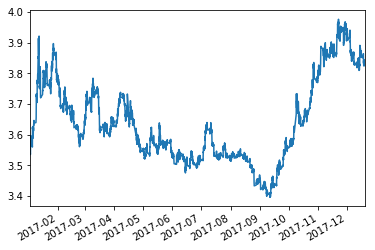

In [60]:
df.bid_c.plot()
plt.show()

In [61]:
df, indicator_list = AddRSI( df, indicator_list, 'bid', timeperiod=14)

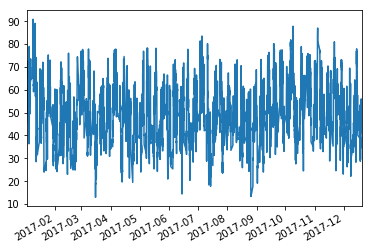

In [62]:
df.rsi.plot()
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001310003D470>]], dtype=object)

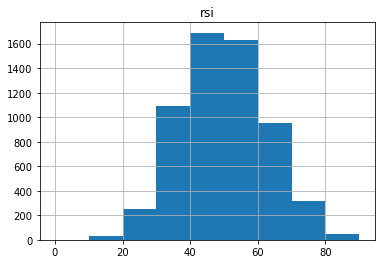

In [63]:
bin_values = np.arange(start=0, stop=100, step=10)
df.hist(column='rsi',bins=bin_values)

In [64]:
lookback = 1
df['return'] = (df['bid_c']/df['bid_c'].shift(lookback))

In [65]:
df['return_to_pred'] = df['return'].shift(-lookback)

In [66]:
df_up = df[df['return_to_pred'] >= 1]['rsi'].dropna()
df_down = df[df['return_to_pred'] < 1]['rsi'].dropna()

In [67]:
bins = np.arange(start=0, stop=110, step=10)

hist_up, bin_edges = np.histogram(df_up.values, bins)
hist_down, bin_edges = np.histogram(df_down.values, bins)

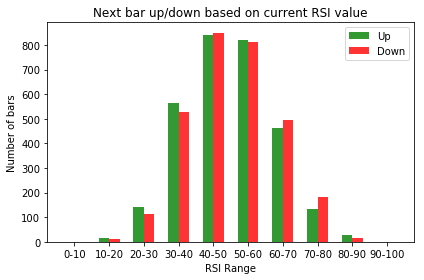

In [68]:
# data to plot
n_groups = bin_edges.size

# create plot
fig, ax = plt.subplots()
index = np.arange(start=0, stop=100, step=10)
bar_width = 3
opacity = 0.8
 
rects1 = plt.bar(index + bar_width/2, hist_up, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Up')
 
rects2 = plt.bar(index + 3/2*bar_width, hist_down, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Down')
 
plt.xlabel('RSI Range')
plt.ylabel('Number of bars')
plt.title('Next bar up/down based on current RSI value')
index_name = [ str(x)+'-'+str(x+10) for x in bin_edges[:-1] ]
plt.xticks(index + bar_width, index_name)
plt.legend()
 
plt.tight_layout()
plt.show()

From this chart, we can conclude:
- when RSI is less than 30, it makes sense to buy
- when RSI is between than 70 and 80, it makes sense to sell. This is slightly contradicting with the general idea of selling when RSI is greater than 70.
This is primarily due to the range of input data and its general down trend in this time range.

In [69]:
df, indicator_list = AddStochRSI( df, indicator_list, 'bid', timeperiod=14)

In [70]:
df.tail()

,ask_o,ask_h,ask_l,ask_c,bid_o,bid_h,bid_l,bid_c,volume,rsi,return,return_to_pred,rsi_fastk,rsi_fastd
2017-12-19 20:00:00,3.83520,3.83607,3.83431,3.83500,3.83323,3.83388,3.83203,3.83257,1546.0,47.296552,0.999828,0.999186,28.894018,18.643365
2017-12-19 21:00:00,3.83500,3.84195,3.83236,3.83757,3.83259,3.83282,3.82165,3.82945,1737.0,44.828954,0.999186,0.998736,0.000000,18.643365
2017-12-19 22:00:00,3.83758,3.84441,3.83656,3.84441,3.82910,3.82990,3.82286,3.82461,195.0,41.234894,0.998736,1.001326,0.000000,9.631339
2017-12-19 23:00:00,3.84439,3.84605,3.83432,3.84196,3.82462,3.83170,3.82447,3.82968,3595.0,46.108951,1.001326,1.000138,74.089184,24.696395
2017-12-20 00:00:00,3.84177,3.84273,3.84177,3.84273,3.82977,3.83151,3.82977,3.83021,98.0,46.607496,1.000138,NaN,88.632543,54.240576


In [71]:
df_up = df[df['return_to_pred'] >= 1]['rsi_fastk'].dropna()
df_down = df[df['return_to_pred'] < 1]['rsi_fastk'].dropna()

In [72]:
bins = np.arange(start=0, stop=110, step=10)

hist_up, bin_edges = np.histogram(df_up.values, bins)
hist_down, bin_edges = np.histogram(df_down.values, bins)

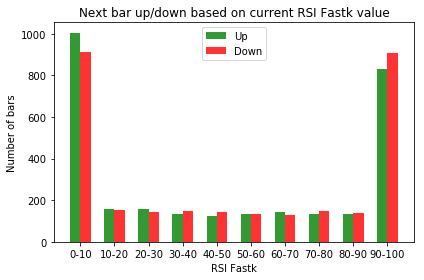

In [73]:
# data to plot
n_groups = bin_edges.size

# create plot
fig, ax = plt.subplots()
index = np.arange(start=0, stop=100, step=10)
bar_width = 3
opacity = 0.8
 
rects1 = plt.bar(index + bar_width/2, hist_up, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Up')
 
rects2 = plt.bar(index + 3/2*bar_width, hist_down, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Down')
 
plt.xlabel('RSI Fastk')
plt.ylabel('Number of bars')
plt.title('Next bar up/down based on current RSI Fastk value')
index_name = [ str(x)+'-'+str(x+10) for x in bin_edges[:-1] ]
plt.xticks(index + bar_width, index_name)
plt.legend()
 
plt.tight_layout()
plt.show()

This is interesting because extreme RSI Fastk value gives a clear edge on when to buy and sell. Furthermore, this is very consistent if one compares with the higher lookback numbers.

In [74]:
df_up = df[df['return_to_pred'] >= 1]['rsi_fastd'].dropna()
df_down = df[df['return_to_pred'] < 1]['rsi_fastd'].dropna()

In [75]:
bins = np.arange(start=0, stop=110, step=10)

hist_up, bin_edges = np.histogram(df_up.values, bins)
hist_down, bin_edges = np.histogram(df_down.values, bins)

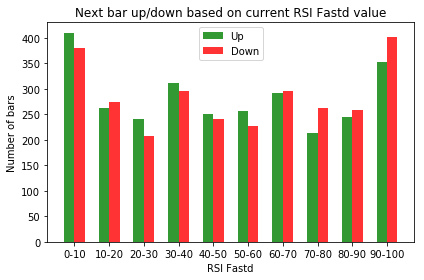

In [76]:
# data to plot
n_groups = bin_edges.size

# create plot
fig, ax = plt.subplots()
index = np.arange(start=0, stop=100, step=10)
bar_width = 3
opacity = 0.8
 
rects1 = plt.bar(index + bar_width/2, hist_up, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Up')
 
rects2 = plt.bar(index + 3/2*bar_width, hist_down, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Down')
 
plt.xlabel('RSI Fastd')
plt.ylabel('Number of bars')
plt.title('Next bar up/down based on current RSI Fastd value')
index_name = [ str(x)+'-'+str(x+10) for x in bin_edges[:-1] ]
plt.xticks(index + bar_width, index_name)
plt.legend()
 
plt.tight_layout()
plt.show()